In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error

unidf=pd.read_csv(r"C:\Users\hajar\Time-Series-Crime-Forecasting-Minneapolis-3\data\Univ_Date.csv")

## SARIMA
1. Split the data into a train and test using time-based splitting
2. Check Assumptions and make corrections if needed
3. Select ARIMA Model
4. Select Best ARIMA Model
4. Interpret

### Split Data

Partition the data set into 4 parts corresponding to 2019-2024. then create nested training sets.

In [58]:
#Validation Set

#sort Data
unidf=unidf.set_index('Date')
unidf=unidf.sort_index()

unidf.reset_index()
unidf['date']=unidf.index
unidf['date'] = pd.to_datetime(unidf['date'], format='%Y-%m-%d')
unidf

,Crime_Count,date
Date,,
2019-01-01,88,2019-01-01
2019-01-02,102,2019-01-02
2019-01-03,133,2019-01-03
2019-01-04,95,2019-01-04
2019-01-05,83,2019-01-05
...,...,...
2025-03-06,89,2025-03-06
2025-03-07,89,2025-03-07
2025-03-08,70,2025-03-08


In [59]:
#Divide Data into 4 pairs of train and test sets

#Partition data by year
df19= unidf[unidf['date'].dt.year == 2019].copy()
df20= unidf[unidf['date'].dt.year == 2020].copy()
df21= unidf[unidf['date'].dt.year == 2021].copy()
df22= unidf[unidf['date'].dt.year == 2022].copy()
df23= unidf[unidf['date'].dt.year == 2023].copy()
df24= unidf[unidf['date'].dt.year == 2024].copy()

#create 2025 df for assessing model
df25=unidf[unidf['date'].dt.year == 2025].copy()

#Drop extra column
df19= df19.drop(columns=['date'])
df20= df20.drop(columns=['date'])
df21= df21.drop(columns=['date'])
df22= df22.drop(columns=['date'])
df23= df23.drop(columns=['date'])
df24= df24.drop(columns=['date'])
df25=df25.drop(columns=['date'])

#Create 4 pairs of train/test sets

train1=pd.concat([df19, df20])
test1=df21

train2=pd.concat([df19,df20, df21])
test2=df22

train3=pd.concat([df19,df20, df21, df22])
test3=df23

train4=pd.concat([df19,df20, df21, df22, df23])
test4=df24

In [60]:
train1 #2019 and 2020

,Crime_Count
Date,
2019-01-01,88
2019-01-02,102
2019-01-03,133
2019-01-04,95
2019-01-05,83
...,...
2020-12-27,55
2020-12-28,129
2020-12-29,101


In [61]:
test1 #2021

,Crime_Count
Date,
2021-01-01,71
2021-01-02,61
2021-01-03,63
2021-01-04,113
2021-01-05,118
...,...
2021-12-27,140
2021-12-28,117
2021-12-29,129


In [62]:
train2 #2019 to 2021

,Crime_Count
Date,
2019-01-01,88
2019-01-02,102
2019-01-03,133
2019-01-04,95
2019-01-05,83
...,...
2021-12-27,140
2021-12-28,117
2021-12-29,129


In [63]:
test2 #2022

,Crime_Count
Date,
2022-01-01,88
2022-01-02,70
2022-01-03,131
2022-01-04,125
2022-01-05,111
...,...
2022-12-27,104
2022-12-28,105
2022-12-29,116


In [64]:
train3 #2019 to 2022

,Crime_Count
Date,
2019-01-01,88
2019-01-02,102
2019-01-03,133
2019-01-04,95
2019-01-05,83
...,...
2022-12-27,104
2022-12-28,105
2022-12-29,116


In [65]:
test3 #2023

,Crime_Count
Date,
2023-01-01,144
2023-01-02,94
2023-01-03,134
2023-01-04,70
2023-01-05,111
...,...
2023-12-27,139
2023-12-28,141
2023-12-29,104


## STEP 1: Set 1 2019-2021
### Checking Stationarity


Text(0, 0.5, '\nNumber of Reported Crimes\n')

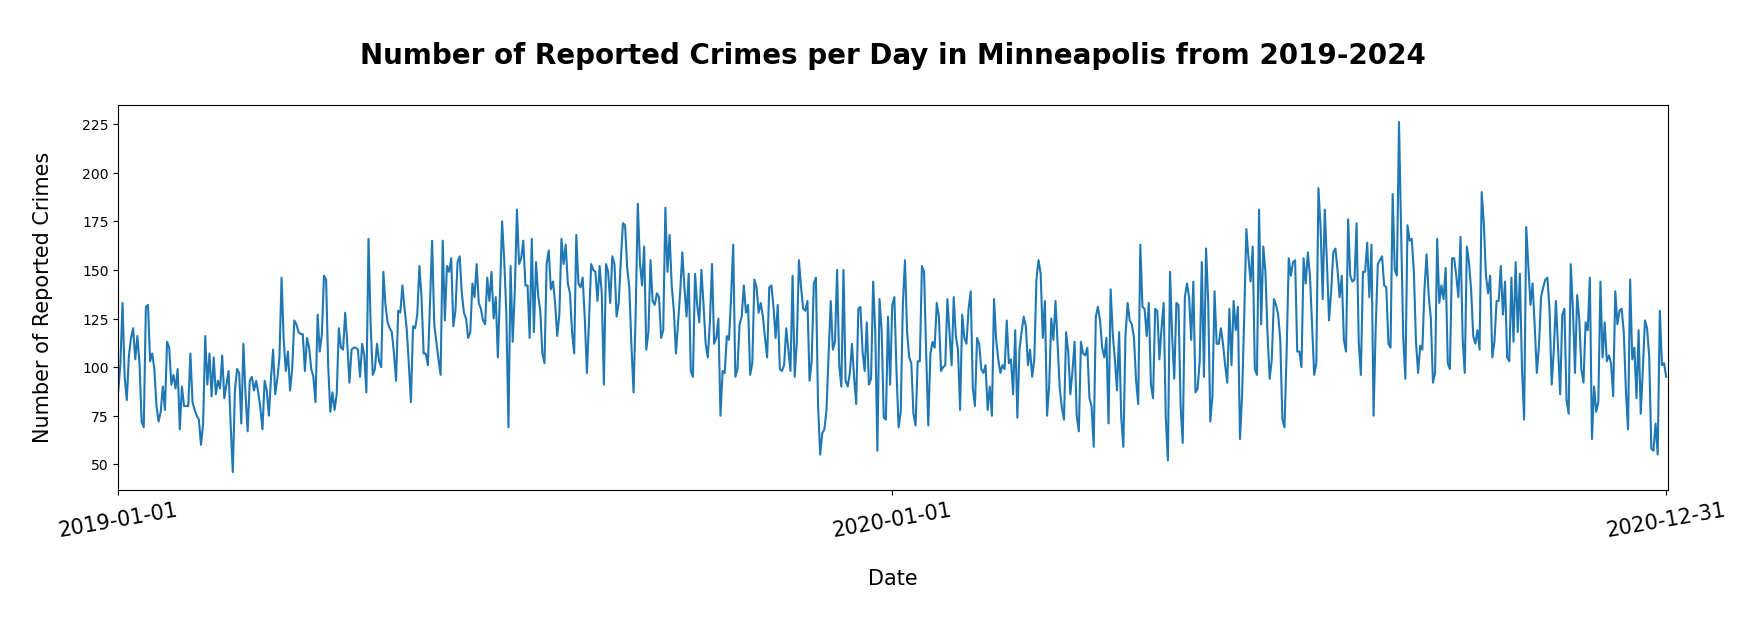

In [66]:
#Look at plot
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train1.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2024-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



In [67]:
#ADF Test

# Perform Augmented Dickey-Fuller test
result = adfuller(train1)

# Extract and print the test statistics and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: -1.5447958387885525
P-value: 0.5112466837476183


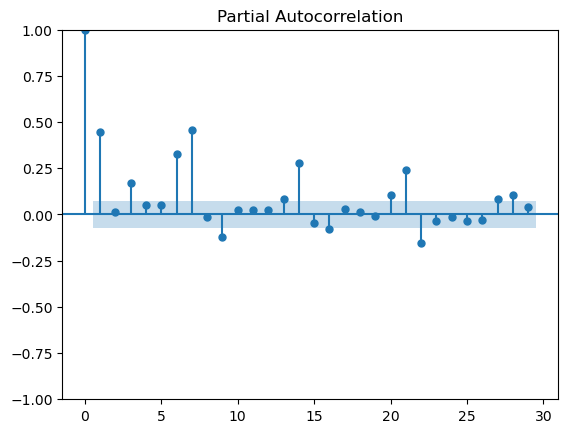

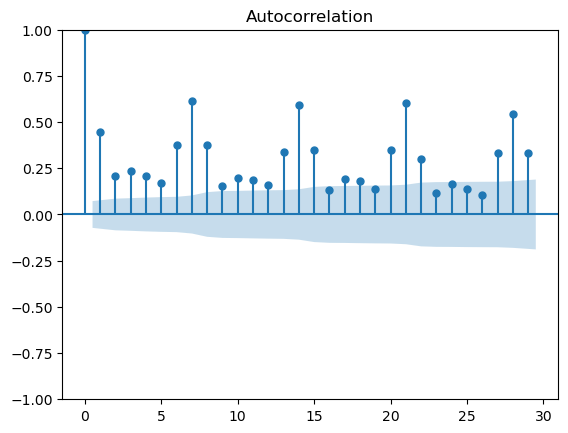

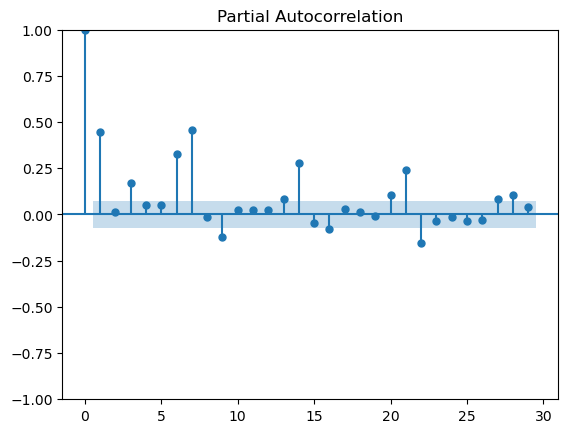

In [68]:
#ACF
plot_acf(train1.Crime_Count.dropna())
#PACF
plot_pacf(train1.Crime_Count.dropna())

### Check for Seasonality

In [69]:
train1['date']=train1.index
train1['date'] = pd.to_datetime(train1['date'], format='%Y-%m-%d')
train1

,Crime_Count,date
Date,,
2019-01-01,88,2019-01-01
2019-01-02,102,2019-01-02
2019-01-03,133,2019-01-03
2019-01-04,95,2019-01-04
2019-01-05,83,2019-01-05
...,...,...
2020-12-27,55,2020-12-27
2020-12-28,129,2020-12-28
2020-12-29,101,2020-12-29


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

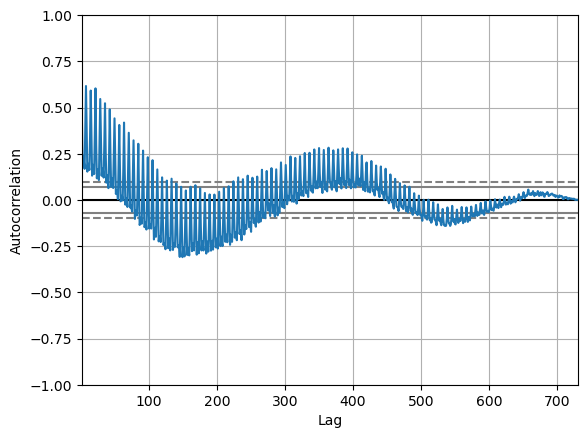

In [70]:
#Autocorrelation
autocorrelation_plot(train1['Crime_Count'])

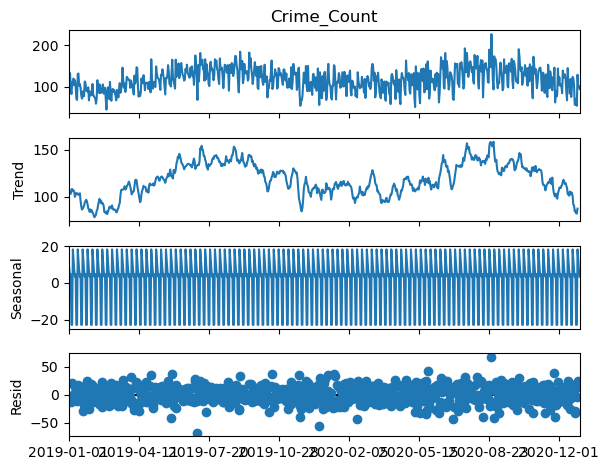

In [71]:
decomposition=seasonal_decompose(train1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train1), 100))
plt.show()

### Seasonal Differencing

In [72]:
train1s1= train1
train1s1['Crime_Count']=train1['Crime_Count'] - train1['Crime_Count'].shift(7)
train1s1=train1s1.dropna()
train1s1

,Crime_Count,date
Date,,
2019-01-08,32.0,2019-01-08
2019-01-09,2.0,2019-01-09
2019-01-10,-17.0,2019-01-10
2019-01-11,7.0,2019-01-11
2019-01-12,-11.0,2019-01-12
...,...,...
2020-12-27,-44.0,2020-12-27
2020-12-28,5.0,2020-12-28
2020-12-29,-19.0,2020-12-29


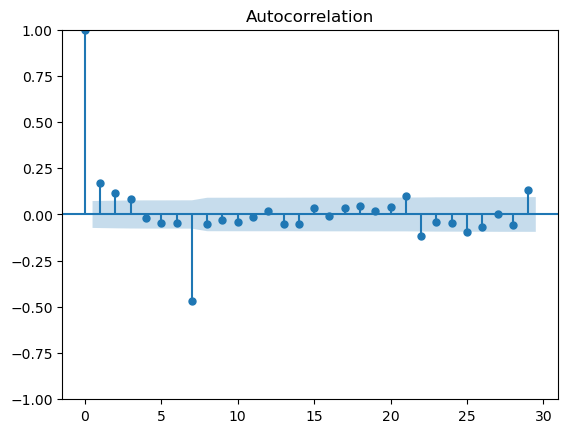

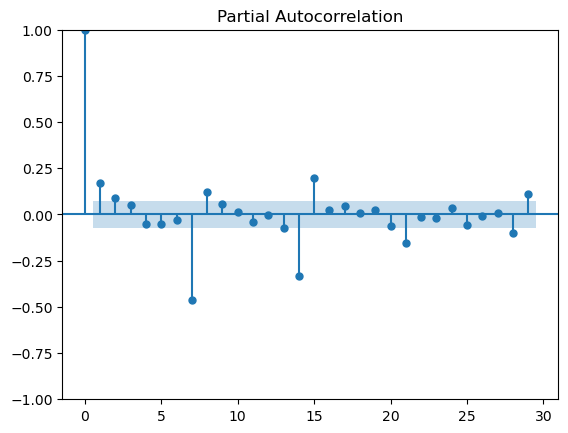

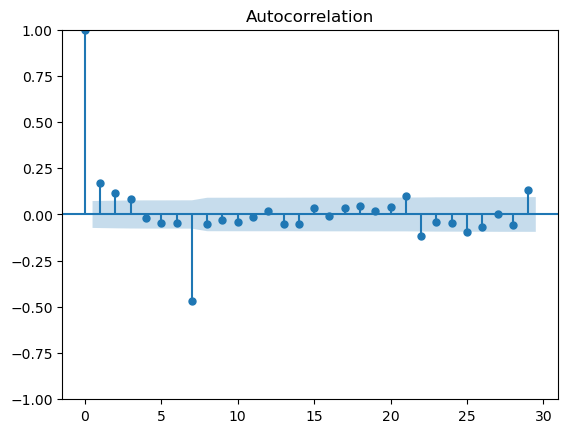

In [73]:
plot_pacf(train1s1.Crime_Count)
plot_acf(train1s1.Crime_Count)

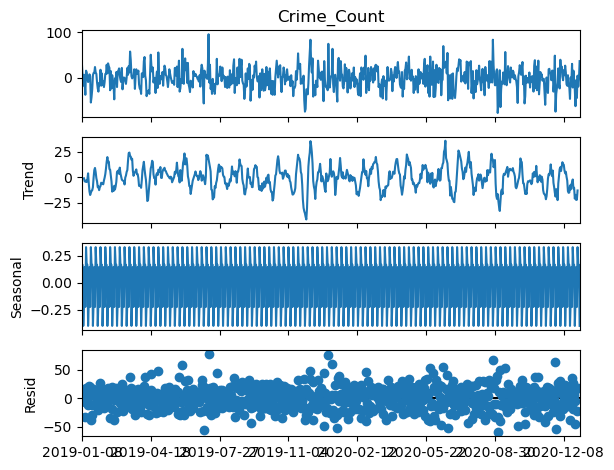

In [74]:
# Trying Differencing of 7
decomposition=seasonal_decompose(train1s1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train1), 100))
plt.show()

In [75]:
#ADF Test

# Perform Augmented Dickey-Fuller test
result = adfuller(train1s1['Crime_Count'])

# Extract and print the test statistics and p-value
test_statistic = result[0]
p_value = result[1]
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")

Test Statistic: -7.930811374734511
P-value: 3.5172964205452434e-12


<Axes: xlabel='Lag', ylabel='Autocorrelation'>

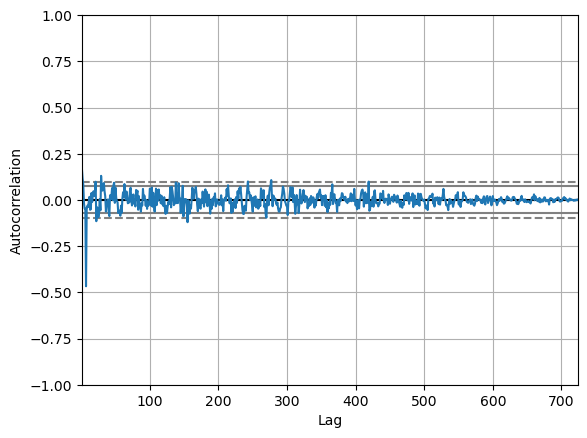

In [76]:
autocorrelation_plot(train1s1['Crime_Count'])

### Determine parameters and Fit Model

In [77]:
#SELECT PARAMETERS using All Subset Selection (AIC)
from itertools import product


def optimize_SARIMA(parameters_list, d, D, s, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in parameters_list:
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(dis=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True)
    return result_df




p = range(0, 3, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 7

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMA(parameters_list, d, D, s, train1s1['Crime_Count'])
result_df


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be 

,"(p,q)x(P,Q)",AIC
47,"(2, 3, 1, 1)",6383.727932
43,"(2, 2, 1, 1)",6416.937907
23,"(1, 1, 1, 1)",6418.240633
35,"(2, 0, 1, 1)",6419.119193
15,"(0, 3, 1, 1)",6419.416805
27,"(1, 2, 1, 1)",6419.753238
39,"(2, 1, 1, 1)",6419.867450
31,"(1, 3, 1, 1)",6420.489154
11,"(0, 2, 1, 1)",6423.261772
19,"(1, 0, 1, 1)",6423.838235


In [78]:
mod1 = SARIMAX(train1s1['Crime_Count'], order=(2,0,3), seasonal_order=(1,1,1,7)).fit(dis=-1)
my_model=SARIMAX(train1s1['Crime_Count'], order=(2, 0, 3), seasonal_order=(0, 1, 1, 7)).fit(dis=-1)
print(f'My Model AIC: {my_model.aic} and the Optimized Model AIC: {mod1.aic}')
print(mod1.summary())


c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword argum

My Model AIC: 6600.223395465004 and the Optimized Model AIC: 6383.727931786705
                                      SARIMAX Results                                      
Dep. Variable:                         Crime_Count   No. Observations:                  724
Model:             SARIMAX(2, 0, 3)x(1, 1, [1], 7)   Log Likelihood               -3183.864
Date:                             Tue, 18 Mar 2025   AIC                           6383.728
Time:                                     23:34:11   BIC                           6420.329
Sample:                                 01-08-2019   HQIC                          6397.861
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1456      

### Model Diagnostics

Figure(640x480)


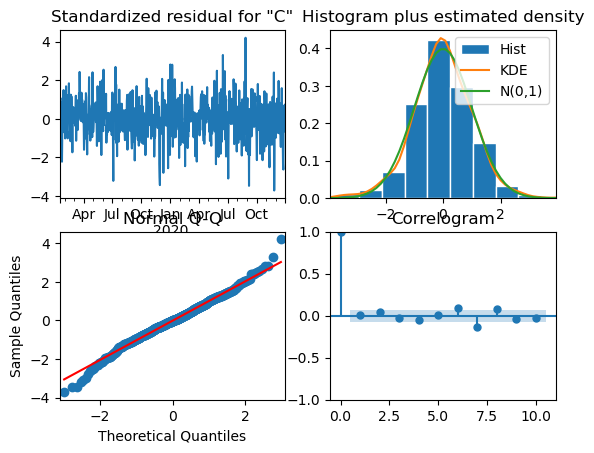

In [79]:
#Model DIAGNOSTICS AND SUMMARY
print(mod1.plot_diagnostics())

### Calculate MAE RMSE MAPE MASE

In [80]:
#MEASURE PERFORMACE METRICS

fcast_len = len(test1)
fcast = mod1.forecast(fcast_len)

mse1 = mean_squared_error(test1, fcast)
rmse1 = np.sqrt(mse1)
mae1 = mean_absolute_error(test1, fcast)
mape1= mean_absolute_percentage_error(test1, fcast)

print(f'Mean Squared Error: {mse1}')
print(f'Root Mean Squared Error: {rmse1}')
print(f'Mean Absolute Error: {mae1}')
print(f'Mean Absolute Percentage Error: {mape1}')



Mean Squared Error: 12875.910969688151
Root Mean Squared Error: 113.47207132016297
Mean Absolute Error: 110.82088728535284
Mean Absolute Percentage Error: 1.0004641506689709


In [81]:
# train1s1['date'] = pd.to_datetime(train1s1['date'])
# fcast['date']= pd.to_datetime(fcast.index)  # Ensure fcast has datetime index
# test1['date'] = pd.to_datetime(test1.index)

# plt.figure(figsize=(20, 10))
# plt.title('Candy Production Forecast', fontsize=30)
# plt.plot(train1s1['Crime_Count'], label='Train')
# plt.plot(fcast, label='Forecast')
# plt.plot(test1['Crime_Count'], label='Test')
# plt.legend(fontsize=25)
# plt.show()

## Repeat FOR STEP 2: Set 2 2019-2021

Text(0, 0.5, '\nNumber of Reported Crimes\n')

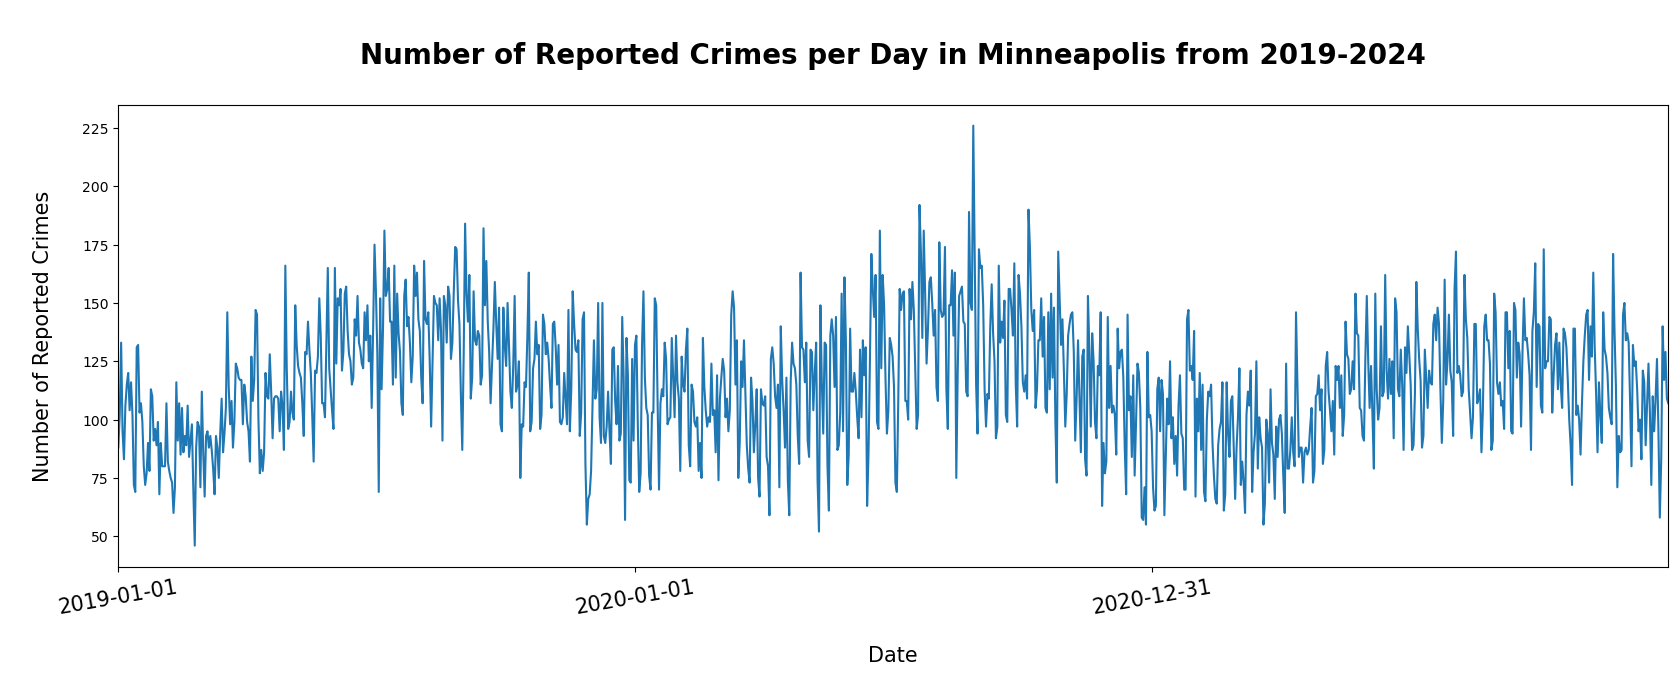

In [82]:
# PLOT
ax.clear()
fig, ax=plt.subplots(figsize=(20, 6))
plt.plot(train2.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2021-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2024\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})

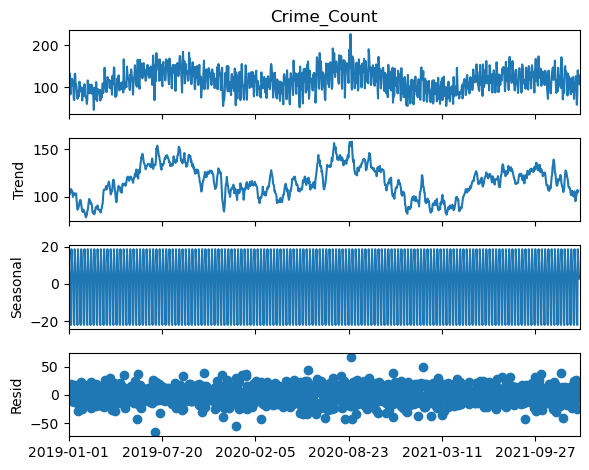

In [83]:
#CHECK STATIONARITY and SEASONALITY
decomposition=seasonal_decompose(train2['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train2), 200))
plt.show()


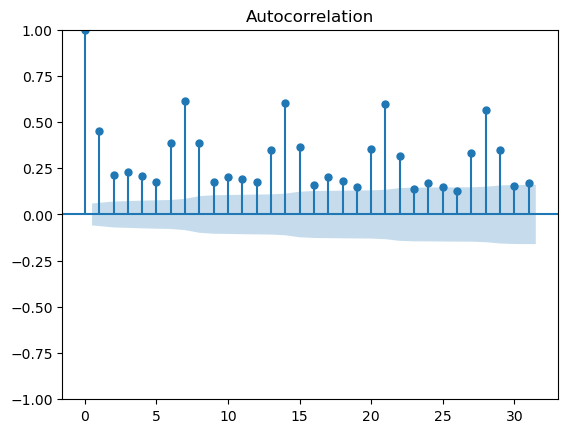

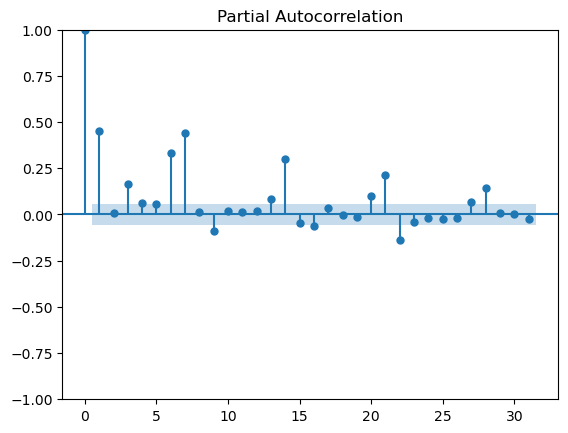

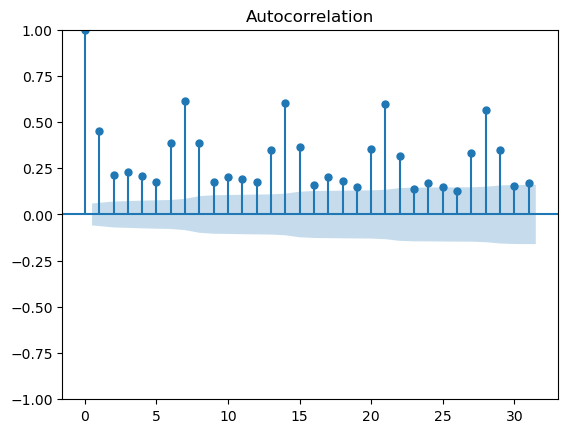

In [84]:
plot_pacf(train2.Crime_Count)
plot_acf(train2.Crime_Count)

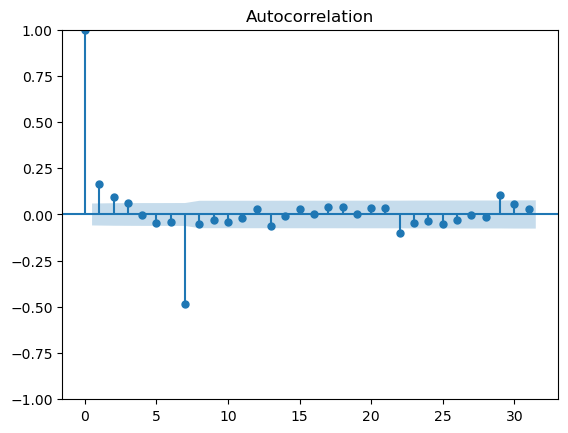

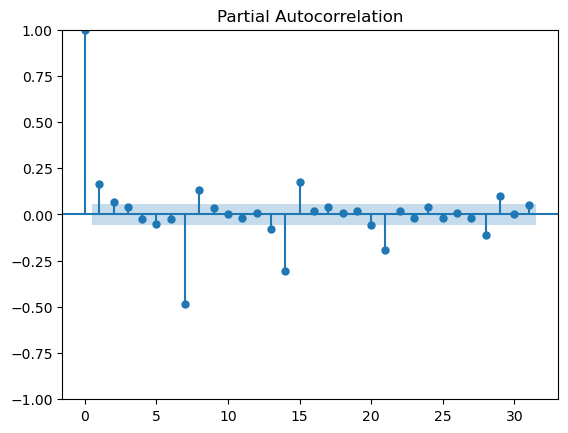

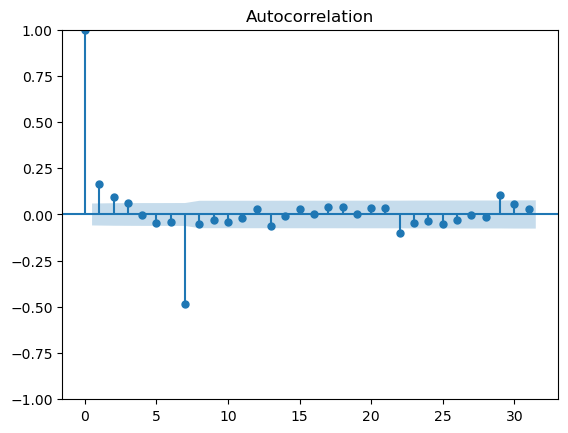

In [85]:
#DIFFERENCE
train2s1= train2
train2s1['Crime_Count']=train2['Crime_Count'] - train2['Crime_Count'].shift(7)
train2s1=train2s1.dropna()

plot_pacf(train2s1.Crime_Count)
plot_acf(train2s1.Crime_Count)

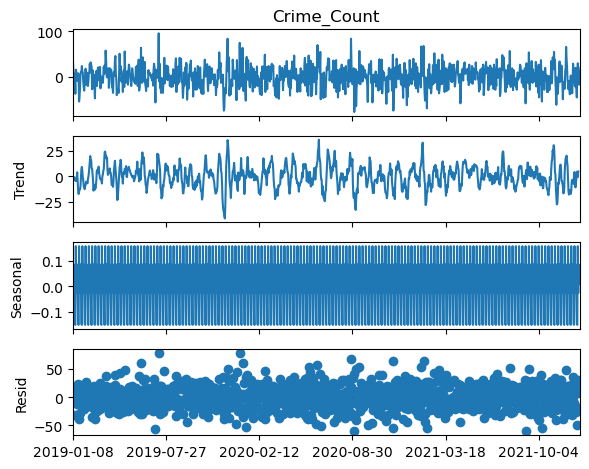

In [86]:
decomposition=seasonal_decompose(train2s1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train2s1), 200))
plt.show()

In [87]:
p = range(0, 2, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 7

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMA(parameters_list, d, D, s, train2s1['Crime_Count'])
result_df

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be 

,"(p,q)x(P,Q)",AIC
23,"(1, 1, 1, 1)",9604.654876
27,"(1, 2, 1, 1)",9606.653460
15,"(0, 3, 1, 1)",9607.080785
31,"(1, 3, 1, 1)",9607.687254
19,"(1, 0, 1, 1)",9608.745446
11,"(0, 2, 1, 1)",9609.869702
7,"(0, 1, 1, 1)",9615.476461
3,"(0, 0, 1, 1)",9656.148018
29,"(1, 3, 0, 1)",9897.411139
21,"(1, 1, 0, 1)",9909.022897


In [88]:
mod2 = SARIMAX(train2s1['Crime_Count'], order=(1,0,1), seasonal_order=(1,1,1,7)).fit(dis=-1)
my_model=SARIMAX(train2s1['Crime_Count'], order=(1, 0, 3), seasonal_order=(0, 1, 1, 7)).fit(dis=-1)
print(f'My Model AIC: {my_model.aic} and the Optimized Model AIC: {mod2.aic}')
print(mod1.summary())

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  w

My Model AIC: 9897.41113871618 and the Optimized Model AIC: 9604.654875753426
                                      SARIMAX Results                                      
Dep. Variable:                         Crime_Count   No. Observations:                  724
Model:             SARIMAX(2, 0, 3)x(1, 1, [1], 7)   Log Likelihood               -3183.864
Date:                             Tue, 18 Mar 2025   AIC                           6383.728
Time:                                     23:35:24   BIC                           6420.329
Sample:                                 01-08-2019   HQIC                          6397.861
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1456      0

Figure(640x480)


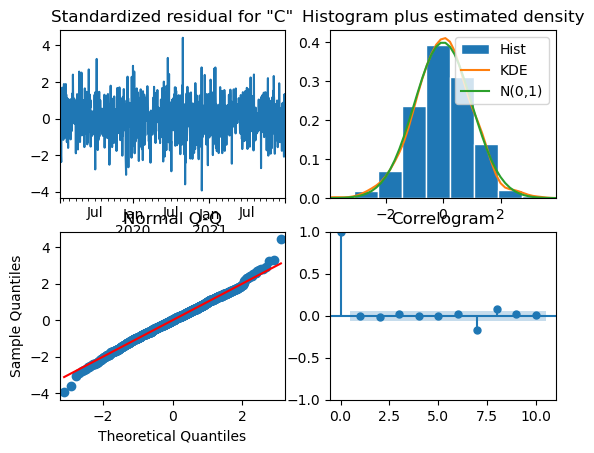

In [89]:
print(mod2.plot_diagnostics())

In [90]:
#FIT MODEL AND CALCULATE MSE

fcast_len = len(test2)
fcast = mod2.forecast(fcast_len)

mse2 = mean_squared_error(test2, fcast)
rmse2 = np.sqrt(mse2)
mae2 = mean_absolute_error(test2, fcast)
mape2= mean_absolute_percentage_error(test2, fcast)

print(f'Mean Squared Error: {mse2}')
print(f'Root Mean Squared Error: {rmse2}')
print(f'Mean Absolute Error: {mae2}')
print(f'Mean Absolute Percentage Error: {mape2}')

Mean Squared Error: 16363.362809934497
Root Mean Squared Error: 127.91936057506892
Mean Absolute Error: 124.46168389492117
Mean Absolute Percentage Error: 0.9998494380360662


## REAPEAT FOR STEP 3: Set 3 2019-2022

Text(0, 0.5, '\nNumber of Reported Crimes\n')

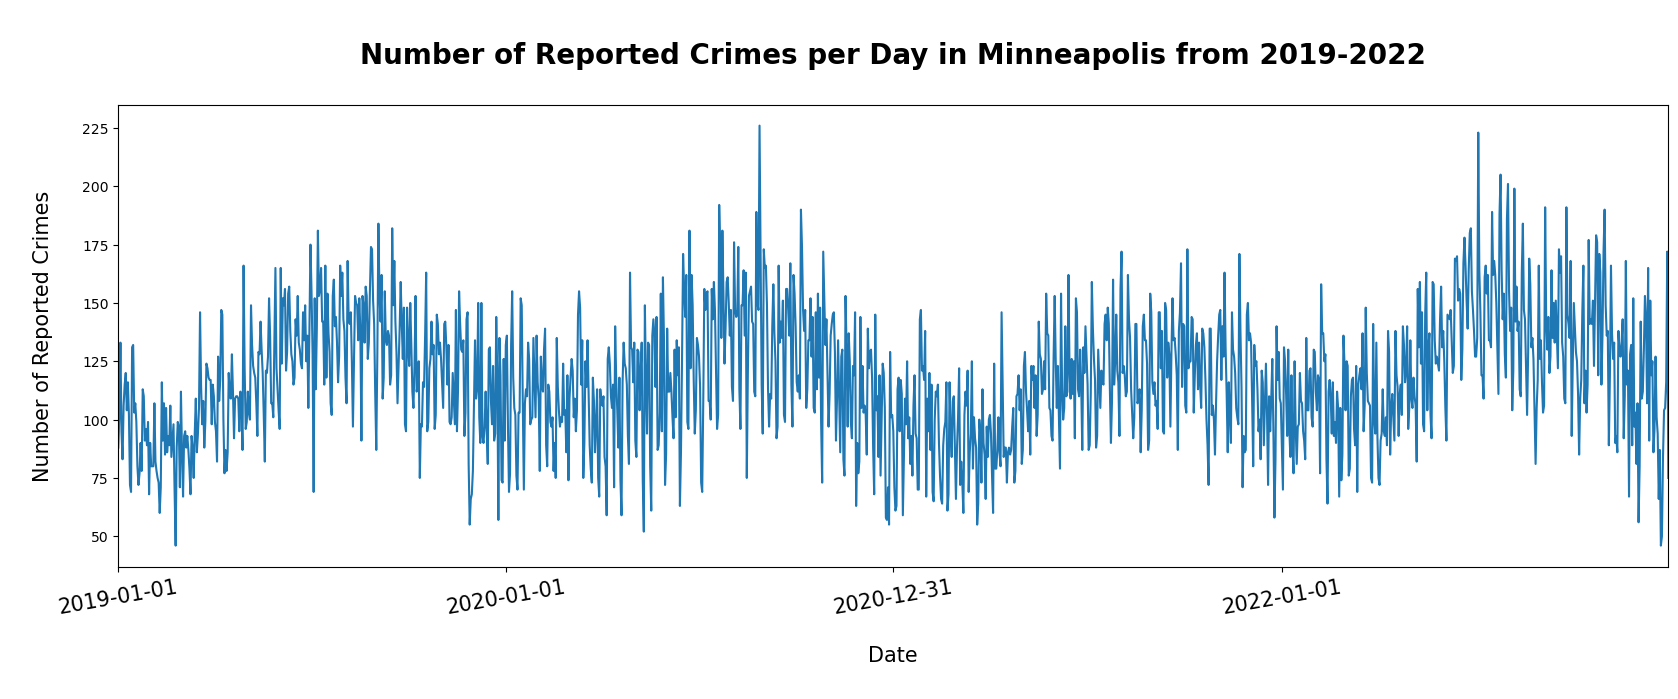

In [91]:
# #PLOT
ax.clear()
fig, ax=plt.subplots(figsize=(20, 6))
plt.plot(train3.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2022-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2022\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



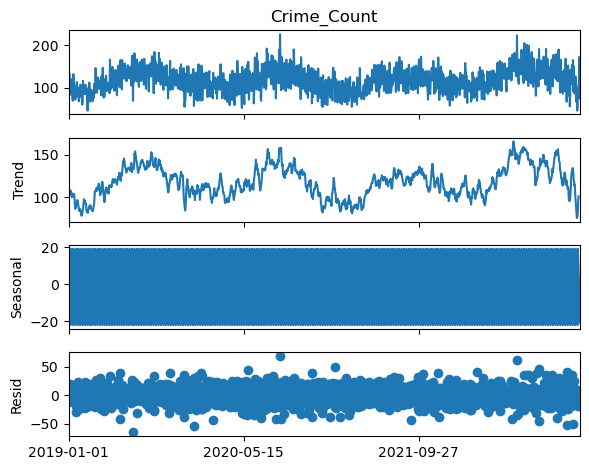

In [92]:
#CHECK STATIONARITY
decomposition=seasonal_decompose(train3['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train3), 500))
plt.show()

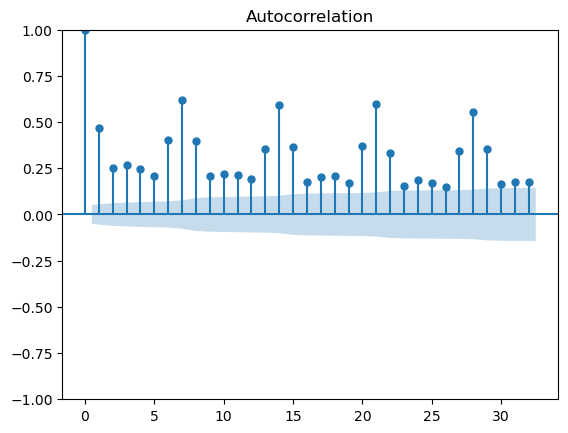

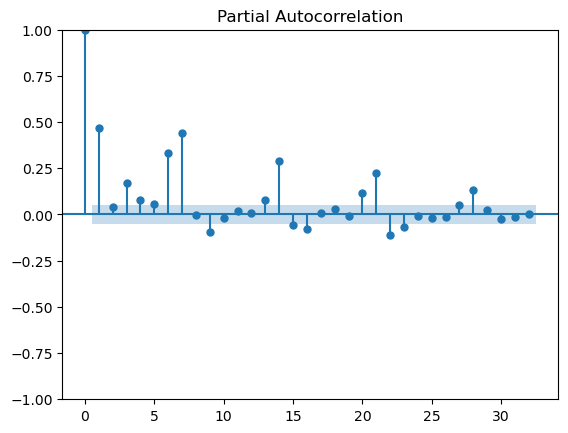

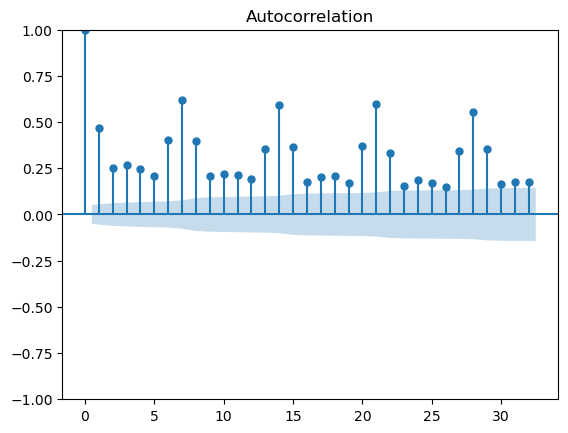

In [93]:
plot_pacf(train3.Crime_Count)
plot_acf(train3.Crime_Count)

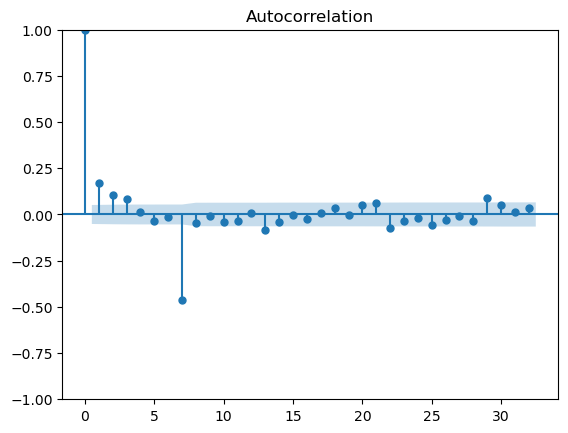

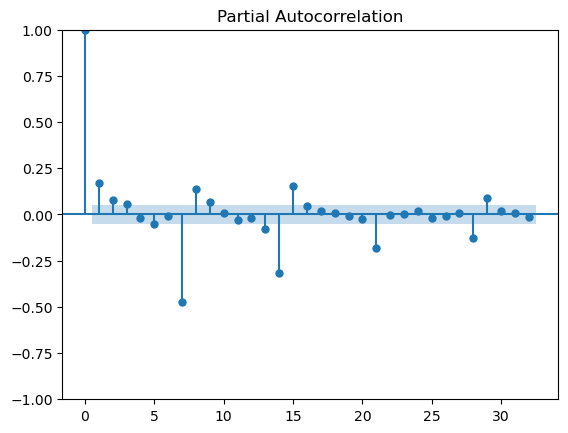

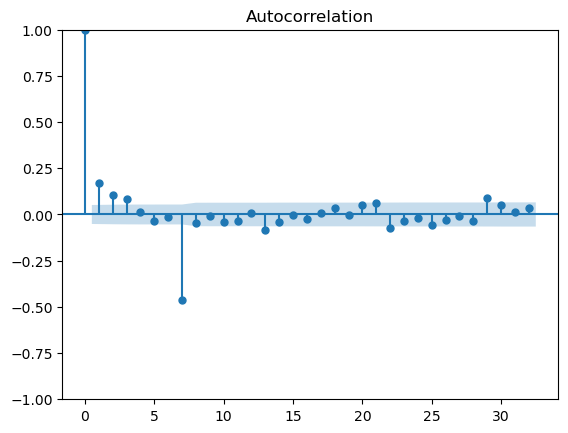

In [94]:
#DIFFERENCE
train3s1= train3
train3s1['Crime_Count']=train3['Crime_Count'] - train3['Crime_Count'].shift(7)
train3s1=train3s1.dropna()

plot_pacf(train3s1.Crime_Count)
plot_acf(train3s1.Crime_Count)

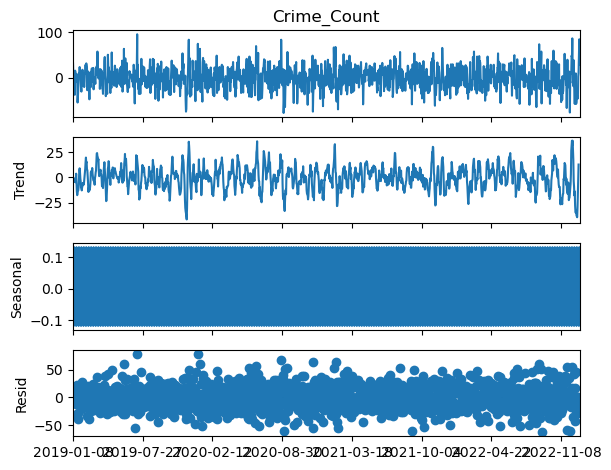

In [95]:
decomposition=seasonal_decompose(train3s1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train3s1), 200))
plt.show()

In [96]:
p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 7

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMA(parameters_list, d, D, s, train3s1['Crime_Count'])
result_df

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be 

,"(p,q)x(P,Q)",AIC
47,"(2, 3, 1, 1)",12822.941144
63,"(3, 3, 1, 1)",12830.752213
43,"(2, 2, 1, 1)",12897.777896
59,"(3, 2, 1, 1)",12898.060531
51,"(3, 0, 1, 1)",12906.279237
...,...,...
52,"(3, 1, 0, 0)",14829.071106
8,"(0, 2, 0, 0)",14831.193764
16,"(1, 0, 0, 0)",14833.180921
4,"(0, 1, 0, 0)",14836.405785


In [97]:
mod3 = SARIMAX(train3s1['Crime_Count'], order=(2,0,3), seasonal_order=(1,1,1,7)).fit(dis=-1)
my_model=SARIMAX(train3s1['Crime_Count'], order=(3, 0, 3), seasonal_order=(0, 1, 1, 7)).fit(dis=-1)
print(f'My Model AIC: {my_model.aic} and the Optimized Model AIC: {mod3.aic}')
print(mod1.summary())

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword argum

My Model AIC: 13086.755228397094 and the Optimized Model AIC: 12822.941144287679
                                      SARIMAX Results                                      
Dep. Variable:                         Crime_Count   No. Observations:                  724
Model:             SARIMAX(2, 0, 3)x(1, 1, [1], 7)   Log Likelihood               -3183.864
Date:                             Tue, 18 Mar 2025   AIC                           6383.728
Time:                                     23:38:37   BIC                           6420.329
Sample:                                 01-08-2019   HQIC                          6397.861
                                      - 12-31-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1456    

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Figure(640x480)


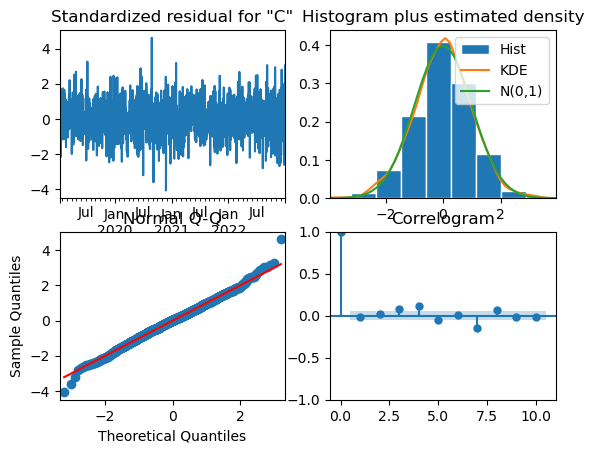

In [98]:
print(mod3.plot_diagnostics())

In [99]:
#FIT MODEL AND CALCULATE MSE
fcast_len = len(test3)
fcast = mod3.forecast(fcast_len)

mse3 = mean_squared_error(test3, fcast)
rmse3 = np.sqrt(mse3)
mae3 = mean_absolute_error(test3, fcast)
mape3= mean_absolute_percentage_error(test3, fcast)

print(f'Mean Squared Error: {mse3}')
print(f'Root Mean Squared Error: {rmse3}')
print(f'Mean Absolute Error: {mae3}')
print(f'Mean Absolute Percentage Error: {mape3}')

Mean Squared Error: 17286.115617265124
Root Mean Squared Error: 131.47667328186063
Mean Absolute Error: 128.3270032864699
Mean Absolute Percentage Error: 1.0015741291535085


## REAPEAT FOR STEP 4: Set 4 2019-2023

Text(0, 0.5, '\nNumber of Reported Crimes\n')

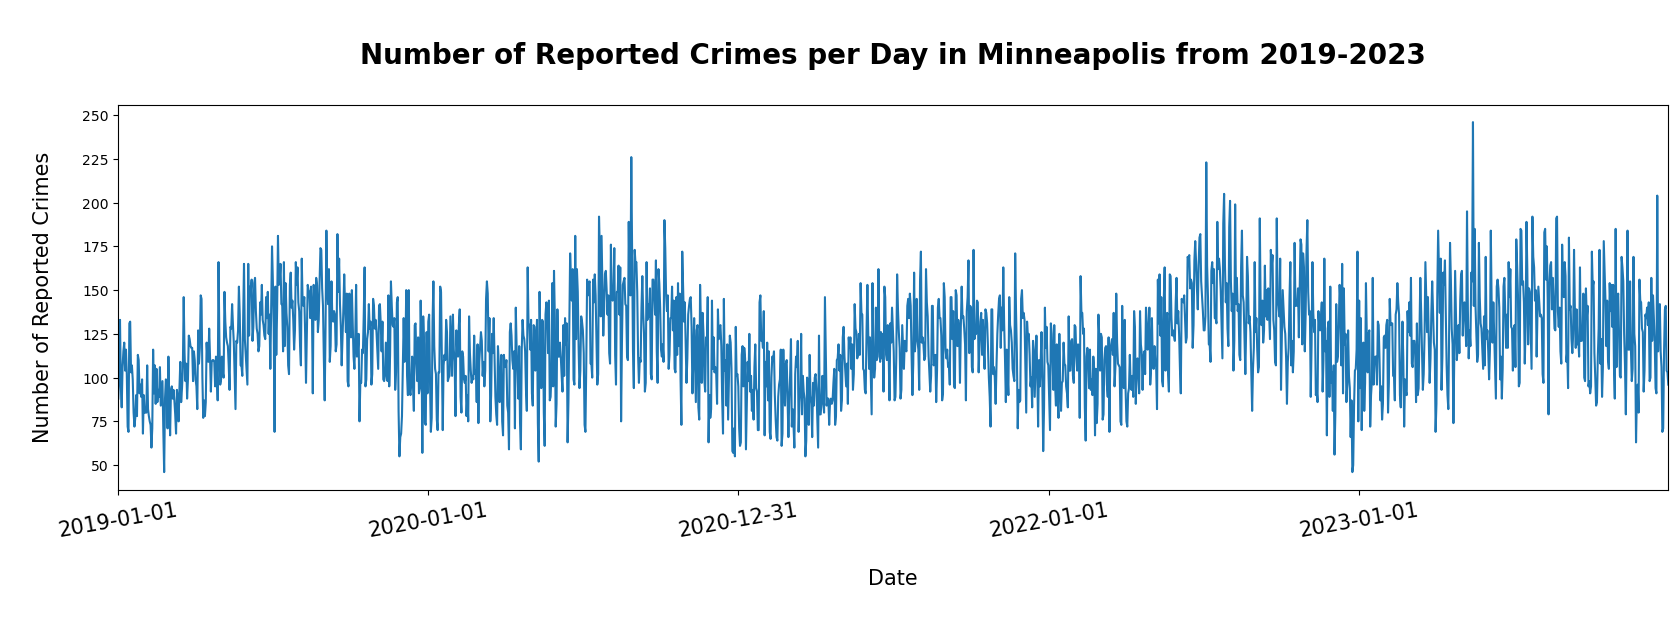

In [100]:
# #PLOT
fig, ax=plt.subplots(figsize=(20, 5))
plt.plot(train4.Crime_Count); 
plt.xticks(rotation=10, fontsize=15)

years = mdates.YearLocator()  
ax.xaxis.set_major_locator(years)

ax.set_xlim('2019-01-01', '2023-12-31')
ax.set_title("\nNumber of Reported Crimes per Day in Minneapolis from 2019-2023\n",weight='bold',fontdict={'fontsize':20})
ax.set_xlabel("\nDate\n",fontdict={'fontsize':15})
ax.set_ylabel("\nNumber of Reported Crimes\n",fontdict={'fontsize':15})



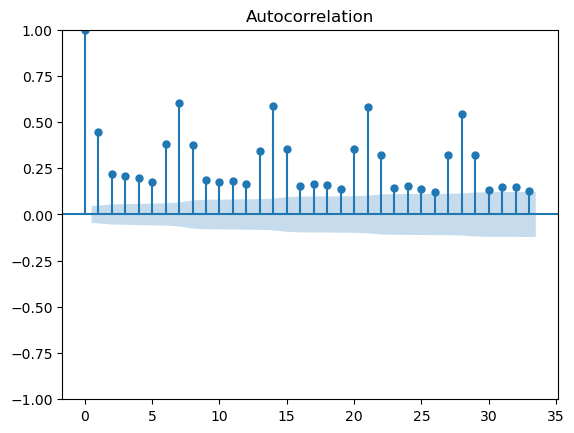

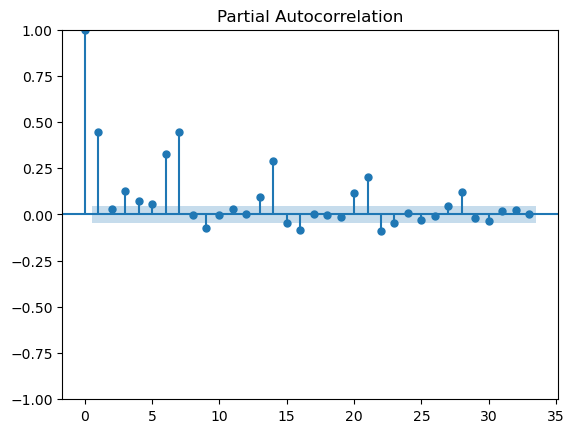

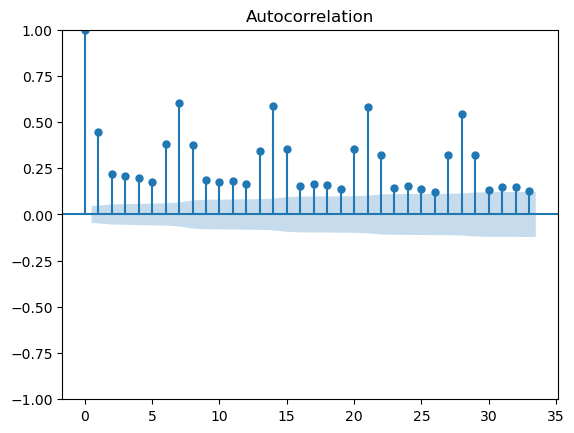

In [101]:
plot_pacf(train4.Crime_Count)
plot_acf(train4.Crime_Count)

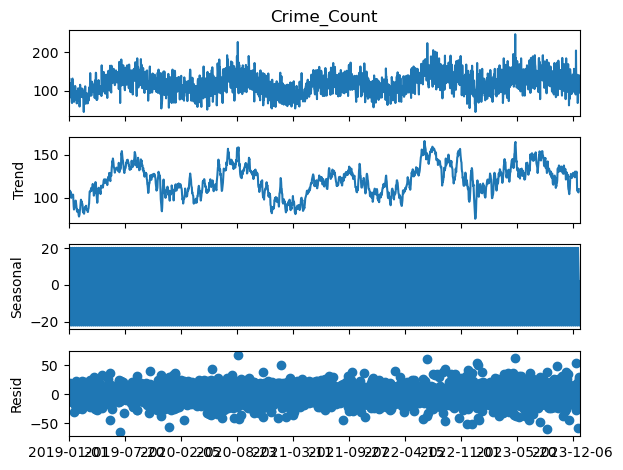

In [102]:
decomposition=seasonal_decompose(train4['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train4), 200))
plt.show()

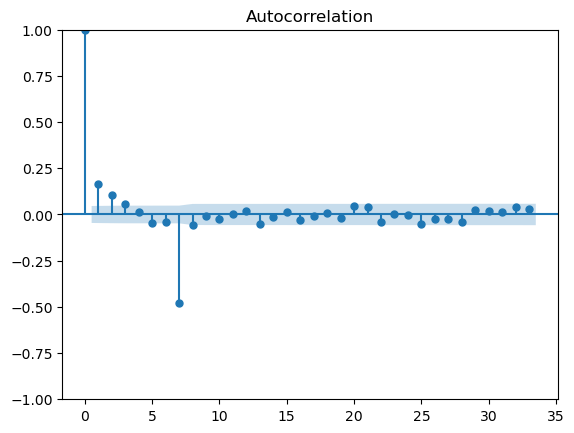

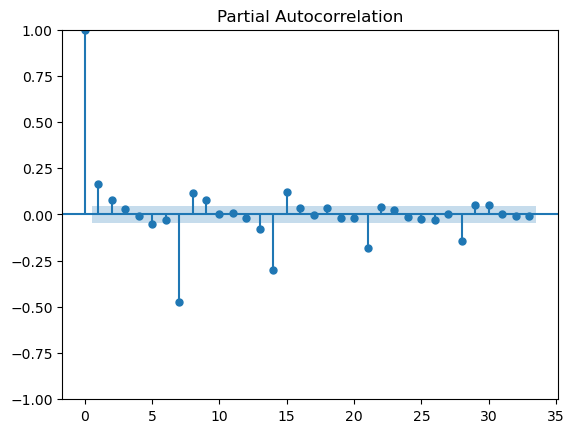

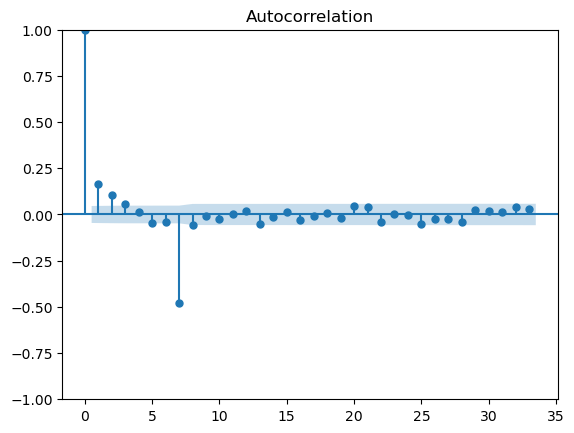

In [103]:
train4s1= train4
train4s1['Crime_Count']=train4['Crime_Count'] - train4['Crime_Count'].shift(7)
train4s1=train4s1.dropna()

plot_pacf(train4s1.Crime_Count)
plot_acf(train4s1.Crime_Count)

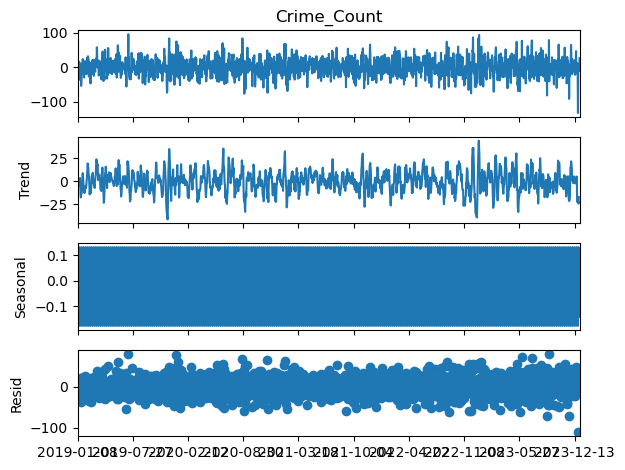

In [104]:
decomposition=seasonal_decompose(train4s1['Crime_Count'],model='additive',period=7)
decomposition.plot()
plt.xticks(ticks=range(0, len(train4s1), 200))
plt.show()

In [114]:
p = range(0, 3, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 2, 1)
D = 1
Q = range(0, 2, 1)
s = 7

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

result_df = optimize_SARIMA(parameters_list, d, D, s, train4s1['Crime_Count'])
result_df

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. The list of allowed keyword arguments for method lbfgs is: m, pgtol, factr, maxfun, epsilon, approx_grad, bounds, loglike_and_score, iprint. The list of unsupported keyword arguments passed include: dis. After release 0.14, this will raise.
  warnings.warn(
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be 

,"(p,q)x(P,Q)",AIC
47,"(2, 3, 1, 1)",16166.815023
43,"(2, 2, 1, 1)",16273.651754
23,"(1, 1, 1, 1)",16285.182454
27,"(1, 2, 1, 1)",16286.567915
39,"(2, 1, 1, 1)",16286.635437
35,"(2, 0, 1, 1)",16287.671342
31,"(1, 3, 1, 1)",16287.938080
15,"(0, 3, 1, 1)",16291.629150
11,"(0, 2, 1, 1)",16296.581084
19,"(1, 0, 1, 1)",16303.060673


In [115]:
mod4 = SARIMAX(train4s1['Crime_Count'], order=(2,0,3), seasonal_order=(1,1,1,7)).fit(dis=-1)
my_model=SARIMAX(train4s1['Crime_Count'], order=(2, 0, 3), seasonal_order=(0, 1, 1, 7)).fit(dis=-1)
print(f'My Model AIC: {my_model.aic} and the Optimized Model AIC: {mod4.aic}')
print(mod4.summary())

c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\ProgramData\anaconda3\Lib\site-packages\statsmodels\base\optimizer.py:19: FutureWarning: Keyword argum

My Model AIC: 16752.53795511661 and the Optimized Model AIC: 16166.815023297106
                                      SARIMAX Results                                      
Dep. Variable:                         Crime_Count   No. Observations:                 1819
Model:             SARIMAX(2, 0, 3)x(1, 1, [1], 7)   Log Likelihood               -8075.408
Date:                             Tue, 18 Mar 2025   AIC                          16166.815
Time:                                     23:59:41   BIC                          16210.833
Sample:                                 01-08-2019   HQIC                         16183.058
                                      - 12-31-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4369     

Figure(640x480)


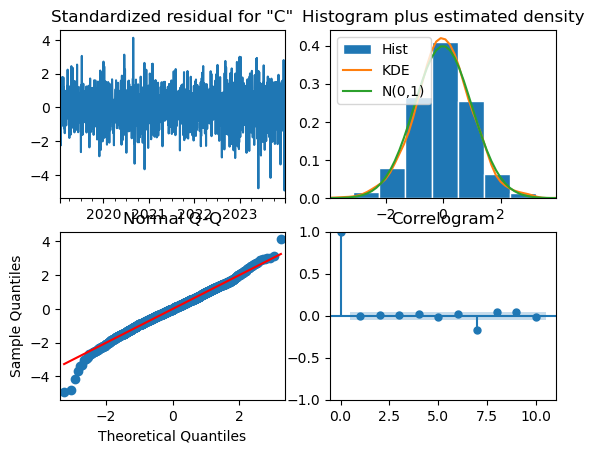

In [107]:
print(mod4.plot_diagnostics())

In [108]:
#FIT MODEL AND CALCULATE MSE
fcast_len = len(test4)
fcast = mod4.forecast(fcast_len)

mse4 = mean_squared_error(test4, fcast)
rmse4 = np.sqrt(mse4)
mae4 = mean_absolute_error(test4, fcast)
mape4= mean_absolute_percentage_error(test4, fcast)

print(f'Mean Squared Error: {mse4}')
print(f'Root Mean Squared Error: {rmse4}')
print(f'Mean Absolute Error: {mae4}')
print(f'Mean Absolute Percentage Error: {mape4}')

Mean Squared Error: 17246.446143354373
Root Mean Squared Error: 131.3257253677069
Mean Absolute Error: 128.1915368827594
Mean Absolute Percentage Error: 0.9986112446186964


## COMPARE SARIMA MODELS

In [117]:
#SARIMA Model
# initialize data of lists.
data = {'Model': ['Model_1', 'Model_2', 'Model_3', 'Model_4'],
        'SARIMA':['(2,0,3)(1,1,1,7)','(1,0,1)(1,1,1,7)','(2,0,3)(1,1,1,7)','(2,0,3)(1,1,1,7)'],
        'MSE': [mse1, mse2, mse3, mse4],
        'RMSE':[rmse1,rmse2,rmse3,rmse4],
        'MAE':[mae1,mae2,mae3,mae4],
        'MAPE':[mape1,mape2,mape3,mape4]}

# Create DataFrame
df = pd.DataFrame(data)

print(df)

     Model            SARIMA           MSE        RMSE         MAE      MAPE
0  Model_1  (2,0,3)(1,1,1,7)  12875.910970  113.472071  110.820887  1.000464
1  Model_2  (1,0,1)(1,1,1,7)  16363.362810  127.919361  124.461684  0.999849
2  Model_3  (2,0,3)(1,1,1,7)  17286.115617  131.476673  128.327003  1.001574
3  Model_4  (2,0,3)(1,1,1,7)  17246.446143  131.325725  128.191537  0.998611


## COMPARE TO AUTO SARIMA

In [110]:
#AUTO SARIMA
from pmdarima.arima import ADFTest
from pmdarima import auto_arima

## Test 1
#Auto Arima

# arima_model = auto_arima(train1s1, start_p=0, d=0, start_q=0,
#     max_p=5, max_d=5, max_q=5,
#     start_P=0, D=1, start_Q=0, max_P=5, max_D=5,
#     max_Q=5, seasonal=True,
#     stationary=False,
#     error_action='warn', trace=True,
#     suppress_warnings=True, stepwise=True,
#     random_state=20, n_fits=50)
## Test 2

## Test 3

## Test 4

## COMPARE TO SARIMAX

In [111]:
#SARIMAX

## COMPARE TO Rolling Forecasting SARIMA

In [112]:
#ROLLING FORECAST SARIMA

## FORECAST ALL FOR 2025

In [113]:
#Forecast 2025
#RMSE	MAE	MAPE	MASE